In [408]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import scipy.stats as stats
import platform

if platform.system() == 'Darwin':
    plt.rc('font', family = 'AppleGothic')
else:
    plt.rc('font', family = 'Malgun Gothic')

import warnings
warnings.filterwarnings('ignore')

import Modeling3
import imp
imp.reload(Modeling3)
from Modeling3 import XGmodeling

In [409]:
# 날짜 정보가 있는 데이터
data = pd.read_csv('최종_동태.csv')
data.index = pd.to_datetime(data['회계년도'])
data.drop('회계년도', axis=1, inplace=True)

In [410]:
## feature selection을 통해 선택된 원래의 train data
df_train_original = pd.read_csv('동태3겹rus_train_origin.csv')
x_columns = list(df_train_original.drop(['부실여부'], axis=1).columns)
x_columns_target = list(df_train_original.columns)
len(x_columns_target)

18

In [411]:
### 학습데이터, 테스트 데이터로 분할
data_test = data[data.index >= datetime.strptime('2021-12-01', '%Y-%m-%d')]
data_train = data[data.index < datetime.strptime('2021-12-01', '%Y-%m-%d')]

# 회사명과 거래소 코드  정보를 남겨놓기 위한거
data_name = data_train[['회사명', '거래소코드']]

In [412]:
# 원래 데이터와 생성된 가짜 데이터가 섞여있는거
df_train_temp = pd.read_csv('CTGAN_oversampled_train_1_1.csv')    ######################### 스모트 비율에 맞는거를 불러오도록 해

In [413]:
# 가짜 데이터 생성
temptemp = df_train_temp[x_columns_target].merge(df_train_original[x_columns_target], indicator=True, how='outer')
df_train_generated = temptemp[temptemp['_merge'] == 'left_only']
df_train_generated.drop(['_merge'], axis=1, inplace=True)

In [414]:
# 진짜 데이터에 날짜 데이터 부여
df_train_original.index = data_train.index

In [415]:
# 테스트 데이터 불러오기
df_test = pd.read_csv('최종_동태_test.csv')
df_test.index = pd.to_datetime(df_test['회계년도'])
df_test.drop('회계년도', axis=1, inplace=True)

In [416]:
# 진짜 데이터를 4개의 폴드로 나눈거
fold1 = df_train_original[(df_train_original.index >= datetime.strptime('2012-12-01', '%Y-%m-%d')) & (df_train_original.index <= datetime.strptime('2014-12-01', '%Y-%m-%d'))].index
fold2 = df_train_original[(df_train_original.index >= datetime.strptime('2015-12-01', '%Y-%m-%d')) & (df_train_original.index <= datetime.strptime('2016-12-01', '%Y-%m-%d'))].index
fold3 = df_train_original[(df_train_original.index >= datetime.strptime('2017-12-01', '%Y-%m-%d')) & (df_train_original.index <= datetime.strptime('2018-12-01', '%Y-%m-%d'))].index
fold4 = df_train_original[(df_train_original.index >= datetime.strptime('2019-12-01', '%Y-%m-%d')) & (df_train_original.index <= datetime.strptime('2020-12-01', '%Y-%m-%d'))].index

In [417]:
# 생성된 데이터에 대해 랜덤하게 날짜를 부여
import random

weights = [len(fold1), len(fold2), len(fold3), len(fold4)]
values = [list(fold1.unique()), list(fold2.unique()), list(fold3.unique()), list(fold4.unique())]
generated_index = []
for i in range(len(df_train_generated.index)):

    selected_list = random.choices(values, weights=weights, k=1)[0]
    selected_value = random.choice(selected_list)
    generated_index.append(selected_value)

df_train_generated.index = generated_index

In [418]:
df_train = pd.concat([df_train_original, df_train_generated], axis=0)

In [419]:
# df_train = df_train_original

In [420]:
df_train['부실여부'].value_counts()

부실여부
0.0    131308
1.0    131308
Name: count, dtype: int64

In [421]:
xg = XGmodeling(df_train, df_test, x_columns)

In [422]:
# params = xg.my_tuning()

In [423]:
# best_params_df = pd.DataFrame([params])
# best_params_df.to_csv('LR_동태2겹_리샘플링안함.csv', index=False)   ##################### 스모트 비율에 맞게 파일명 바꿔가면서 저장해

In [424]:
#### 여기는 csv 파일 불러오는거니 일단은 신경 안써도 됨
param_info = pd.read_csv('XGboost_동태3겹_ctgan1.csv')
# weights = (df_train['부실여부'].value_counts()[0]/(df_train['부실여부'].value_counts()[1]))/2
# param_info['scale_pos_weight'] = weights
param_dict = {}
for column in param_info:
    param_dict[column] = param_info[column].iloc[0]

In [425]:
param_dict

{'colsample_bytree': 0.9512247820145744,
 'gamma': 0.2845634892328937,
 'learning_rate': 0.1632477527456314,
 'max_depth': 8,
 'min_child_weight': 0.5624808560266128,
 'n_estimators': 29,
 'subsample': 0.8634009766779391}

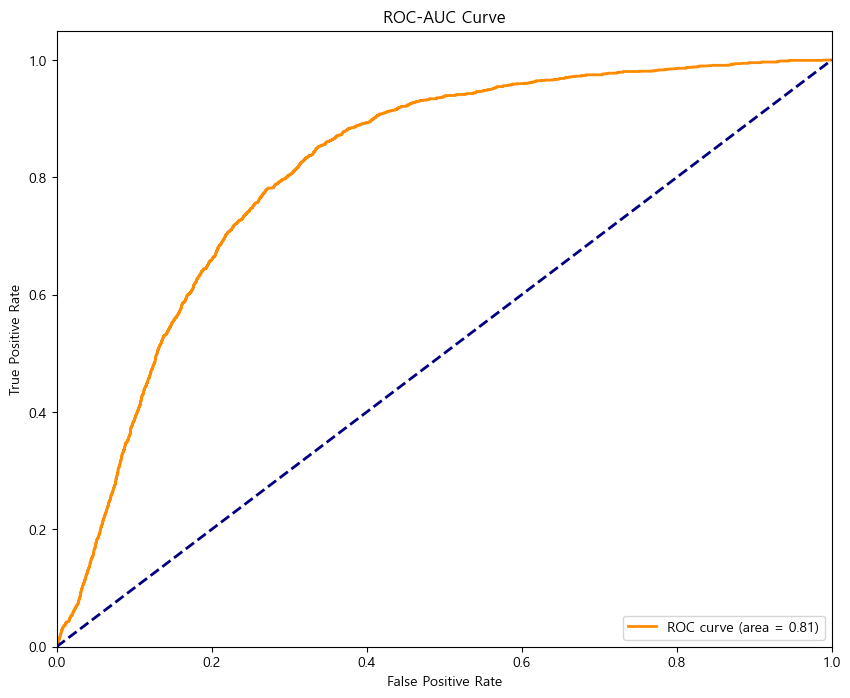

Threshold : 0.1173918
혼돈행렬 : [[28490  7965]
 [  531  1257]]
정확도 : 0.7778
정밀도 : 0.1363
재현율 : 0.703
roc_auc 스코어 : 0.8129
f1 스코어 : 0.2283
f2 스코어 : 0.3838




In [426]:
xg.my_modeling(param_dict)